# <a id='toc1_'></a>[UCRB Snowcourse Investigation](#toc0_)
Author: Daniel Hogan
Creater: August 10, 2023

This notebook will download snow course dat from the NRCS using the `metloom` package and find the nearest snow courses that span 1964-2022 within the headwater basins we analyzed. Then, we will plot the relationship between these peak SWE snow course observations and annual streamflow.

**Table of contents**<a id='toc0_'></a>    
- [UCRB Snowcourse Investigation](#toc1_)    
    - [Imports](#toc1_1_1_)    
- [Site Selection, Data Download, and Filtering](#toc2_)    
    - [Grab snow course locations within the UCRB boundary](#toc2_1_1_)    
    - [Grab snow course data between 1964 and 2022 from the locations above](#toc2_1_2_)    
    - [Find the snow course for each year that is closest to April 1 SWE](#toc2_1_3_)    
    - [Clean up and filter data to only show courses with >90% of observations](#toc2_1_4_)    
- [Tests for significant change](#toc3_)    
    - [Select HCDN basins](#toc3_1_1_)    
    - [Find sites with significant changes in snow course measurements between periods](#toc3_1_2_)    
    - [Plot results](#toc3_1_3_)    
- [Compare SWE and Annual Streamflow](#toc4_)    
    - [Grab all site locations and convert values to new CRS](#toc4_1_1_)    
    - [Find the snow course closest to the centroid of each basin](#toc4_1_2_)    
    - [Select basins with significant and insiginificant reductions in spring precipitation](#toc4_1_3_)    
    - [Collect streamflow data](#toc4_1_4_)    
    - [Linear regression relationship between April 1 SWE and Annual Q](#toc4_1_5_)    
    - [Tests for significant change between periods](#toc4_1_6_)    
- [Figure 1B - SWE - Q relationship shift between periods](#toc5_)    
    - [Linear Regression Plots with spring precipitation added](#toc5_1_1_)    
    - [Multi linear regression with q as the dependent variable and SWE and spring precipitation as the independent variables](#toc5_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# <a id='toc2_'></a>[Site Selection, Data Download, and Filtering](#toc0_)

### <a id='toc2_1_1_'></a>[Grab snow course locations within the UCRB boundary](#toc0_)

In [2]:
fp = '../data/geodata/Upper_Colorado_River_Basin_Boundary.json'
obj = gpd.read_file(fp)

if os.path.exists('../data/geodata/snowcourse_locs.geojson'):
    df = gpd.read_file('../data/geodata/snowcourse_locs.geojson', driver='GeoJSON')
else:
    vrs = [
        SnotelVariables.SWE,
        SnotelVariables.SNOWDEPTH
    ]
    points = SnotelPointData.points_from_geometry(obj, vrs, snow_courses=True)
    df = points.to_dataframe()


### <a id='toc2_1_2_'></a>[Grab snow course data between 1964 and 2022 from the locations above](#toc0_)

In [3]:
if os.path.exists('../data/snowdata/ucrb_snow_course_swe.nc'):
    ds = xr.open_dataset('../data/snowdata/ucrb_snow_course_swe.nc')
else:
    for i,snowcourse in enumerate(df['id'].unique()[63:]):
        name = df[df['id'] == snowcourse].name
        # first test to see if none is returned for the snowcourse
        snowcourse_point = SnotelPointData(snowcourse, name)
        test1 = snowcourse_point.get_snow_course_data(
            dt.datetime(1963,10, 1),
            dt.datetime(1968, 9, 30),
            [snowcourse_point.ALLOWED_VARIABLES.SWE])
        test2 = snowcourse_point.get_snow_course_data(
            dt.datetime(2018,10, 1),
            dt.datetime(2022, 9, 30),
            [snowcourse_point.ALLOWED_VARIABLES.SWE])
        if (test1 is None) or (test2 is None):
            pass
        else:
            data = snowcourse_point.get_snow_course_data(
                dt.datetime(1963,10, 1), 
                dt.datetime(2022, 9, 30),
                [snowcourse_point.ALLOWED_VARIABLES.SWE]).drop_duplicates()
            if i == 1000:
                ds = data.loc[~data.index.duplicated()].to_xarray()
                ds['datetime'] = pd.DatetimeIndex(ds['datetime'].values)
            else:
                tmp = data.loc[~data.index.duplicated()].to_xarray()
                tmp['datetime'] = pd.DatetimeIndex(tmp['datetime'].values)
                ds = xr.merge([ds, tmp])
            # # convert swe to mm
            ds['SWE'] = ds['SWE'] * 25.4
            # save ds['SWE'] to a netcdf file
            ds['SWE'].to_netcdf('../data/snowdata/ucrb_snow_course_swe.nc')

### <a id='toc2_1_3_'></a>[Find the snow course for each year that is closest to April 1 SWE](#toc0_)

In [4]:
# for each year find the value closest to april 1
dates = []
for site in ds['site'].values:
    for year in range(1963,2022):
        month = 4
        day = 1
        val = ds['SWE'].sel(site=site).dropna(dim='datetime').sel(datetime=dt.date(year,month,day), method='nearest')
        if (abs(pd.to_datetime(val.datetime.values).to_pydatetime() - dt.datetime(year, month, day)).days < 14):
            dates.append(pd.to_datetime(val.datetime.values).to_pydatetime())
        


In [5]:
# remove duplicate values from dates
dates_list = list(set(dates))
# select these dates
ds_subset  = ds.sel(datetime=dates_list).where(ds.SWE>0)
# get pre and post-2000 snow course data
pre_snow_course_data = ds_subset.where(ds_subset.datetime.dt.date<dt.date(2000,1,1), drop=True).sortby('datetime')
post_snow_course_data = ds_subset.where(ds_subset.datetime.dt.date>dt.date(2000,1,1), drop=True).sortby('datetime')

### <a id='toc2_1_4_'></a>[Clean up and filter data to only show courses with >90% of observations](#toc0_)

In [6]:
counts_pre = pre_snow_course_data.count(dim='datetime')
# drop sites with less than 30 observations
pre_snow_course_data_filtered = pre_snow_course_data.where(counts_pre >= 32, drop=True)

counts_post = post_snow_course_data.count(dim='datetime')
# drop sites with less than 17 observations
post_snow_course_data_filtered = post_snow_course_data.where((counts_post >= 19) & 
                                                             (post_snow_course_data.site.isin(pre_snow_course_data_filtered.site)), drop=True)

# filter pre course data to only include sites that have post course data
pre_snow_course_data_filtered = pre_snow_course_data_filtered.where(pre_snow_course_data_filtered.site.isin(post_snow_course_data_filtered.site), drop=True)                                                             

# <a id='toc3_'></a>[Tests for significant change](#toc0_)

### <a id='toc3_1_1_'></a>[Select HCDN basins](#toc0_)

In [7]:
hcdn_basins = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
hcdn_basins = hcdn_basins.set_index('STAID')
hcdn_basins = hcdn_basins.set_crs(32613,allow_override=True).to_crs(epsg=4326)

### <a id='toc3_1_2_'></a>[Find sites with significant changes in snow course measurements between periods](#toc0_)

In [8]:
# find sites that have significant differences on pre and post snow course measurements
significant_decrease_sites = []
significant_increase_sites = []
no_significant_change = []
for site in pre_snow_course_data_filtered.site.values:
    pre = pre_snow_course_data_filtered.sel(site = site).SWE.dropna(dim='datetime').values
    post = post_snow_course_data_filtered.sel(site = site).SWE.dropna(dim='datetime').values
    if stats.ttest_ind(post,pre,equal_var=False,alternative='less').pvalue <= 0.05:
        significant_decrease_sites.append(site)
    elif stats.ttest_ind(post,pre,equal_var=False,alternative='greater').pvalue <= 0.05:
        significant_increase_sites.append(site)
    else:
        no_significant_change.append(site)

### <a id='toc3_1_3_'></a>[Plot results](#toc0_)

Text(0.5, 1.0, 'Snow Course Sites with Significant Change in March 1 SWE\nbetween Baseline and Millennium Drought Periods')

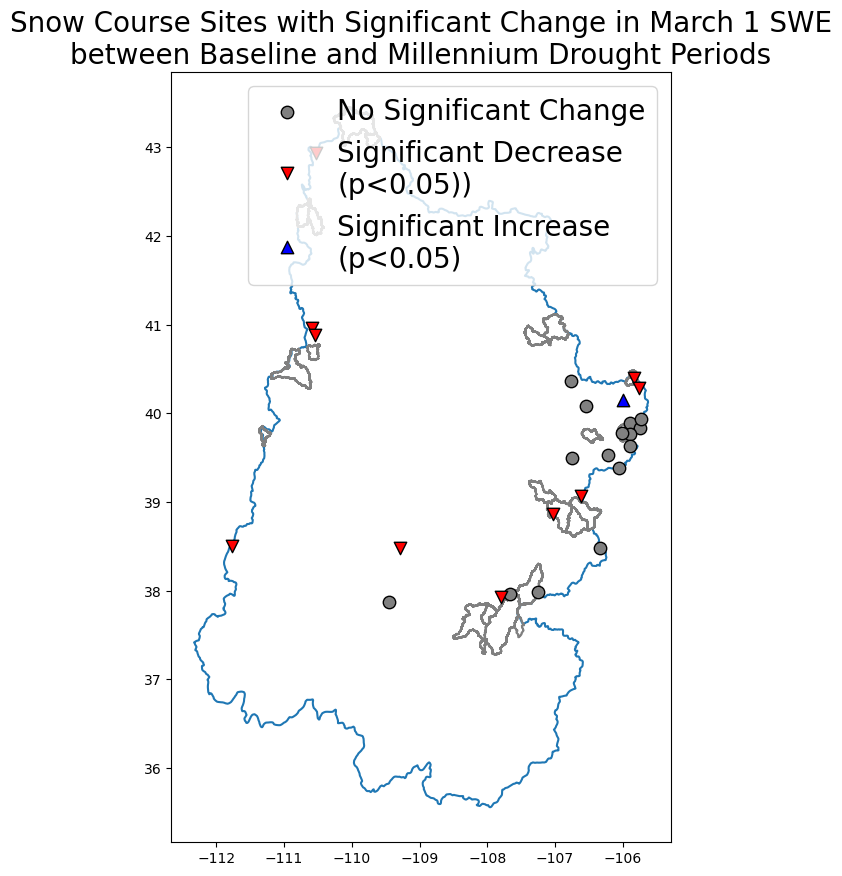

In [9]:
# plot where these changes are 
# plot the snow course locations
fig, ax = plt.subplots(figsize=(10,10))
obj.boundary.plot(ax=ax,zorder=0)
# plot the hcdn basin boundary
hcdn_basins.boundary.plot(ax=ax, color='grey', zorder=1)
# plot the snow course locations
df[df['id'].isin(no_significant_change)].plot(ax=ax, color='grey', markersize=80, ec='k', marker='o', label='No Significant Change')
df[df['id'].isin(significant_decrease_sites)].plot(ax=ax, color='red', markersize=80, ec='k', marker='v', label='Significant Decrease\n(p<0.05))')
df[df['id'].isin(significant_increase_sites)].plot(ax=ax, color='blue', markersize=80, ec='k', marker='^', label='Significant Increase\n(p<0.05)')
# add legend
ax.legend(loc='upper right', fontsize=20)
# add title
ax.set_title('Snow Course Sites with Significant Change in March 1 SWE\nbetween Baseline and Millennium Drought Periods', fontsize=20)


# <a id='toc4_'></a>[Compare SWE and Annual Streamflow](#toc0_)

### <a id='toc4_1_1_'></a>[Grab all site locations and convert values to new CRS](#toc0_)

In [10]:
# analysis values
sites_in_analysis = df[(df['id'].isin(no_significant_change)) | (df['id'].isin(significant_increase_sites)) | (df['id'].isin(significant_decrease_sites))]
sites_in_analysis = sites_in_analysis.to_crs(32613)
hcdn_basins_32613 = hcdn_basins.to_crs(32613)


### <a id='toc4_1_2_'></a>[Find the snow course closest to the centroid of each basin](#toc0_)

In [29]:
# find snow courses closest to the centroid of each basin
basin_snowcourses_nearest = gpd.sjoin_nearest(hcdn_basins_32613, sites_in_analysis, how='inner', max_distance=100000)
# drop duplicate index
basin_snowcourses_nearest = basin_snowcourses_nearest[~basin_snowcourses_nearest.index.duplicated(keep='last')]

### <a id='toc4_1_3_'></a>[Select basins with significant and insiginificant reductions in spring precipitation](#toc0_)

In [30]:
large_spring_p_change = basin_snowcourses_nearest.index
large_spring_p_change_snowcourse = basin_snowcourses_nearest[basin_snowcourses_nearest.index.isin(large_spring_p_change)]
# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_12030609.nc')
# hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt'})
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)

spring_p_change = hcdn_seasonal_ppt.sel(station_id=large_spring_p_change_snowcourse.index).where(hcdn_seasonal_ppt.month.dt.month==3,drop=True)
spring_p_change['month'] = spring_p_change.month.dt.year

large_spring_p_ds = ds_subset.sel(site=large_spring_p_change_snowcourse.id.values).sortby('datetime')

### <a id='toc4_1_4_'></a>[Collect streamflow data](#toc0_)

In [31]:
# import annual streamflow totals
# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/selected_hcdn_basin_chars_and_daily_q.nc')

hcdn_annual_q = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')

In [32]:
# select all basins with a snow course
hcdn_annual_q = hcdn_annual_q.sel(site_no=basin_snowcourses_nearest.index)

### <a id='toc4_1_5_'></a>[Linear regression relationship between April 1 SWE and Annual Q](#toc0_)

The second plot shows the relationship between the linear regression residuals and spring precipitation. Note the relatively strong relationship between these variables.

/tmp/ipykernel_5928/934841150.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2, figsize=(10,4), tight_layout=True)


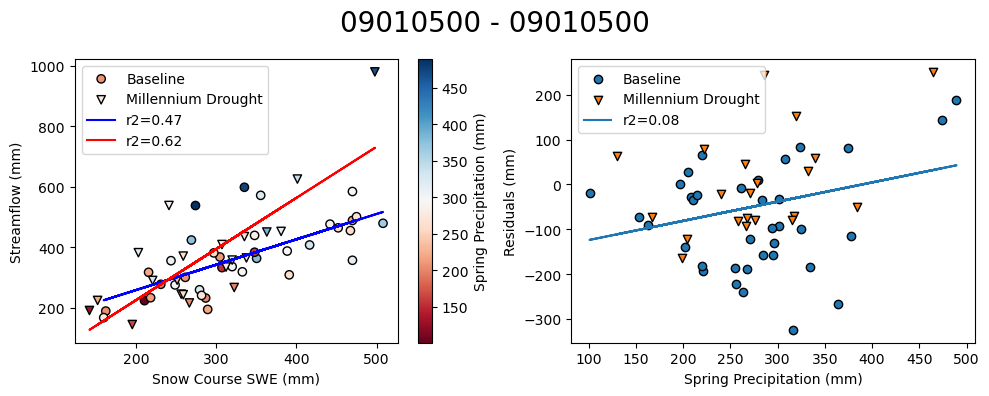

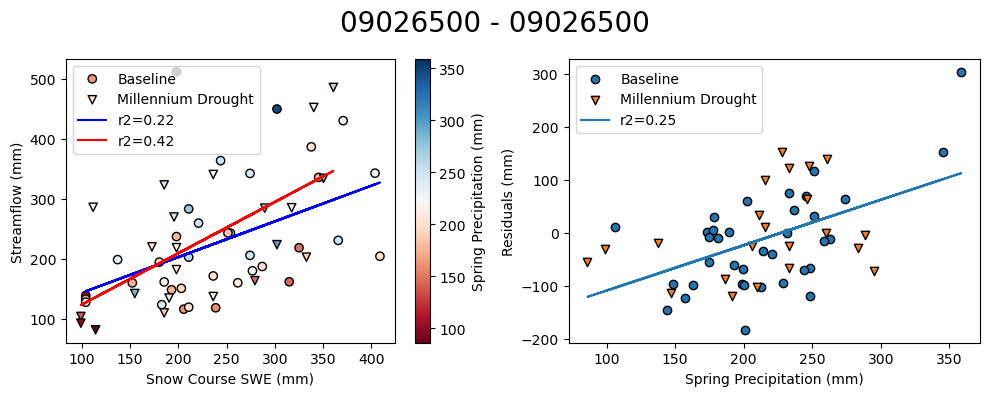

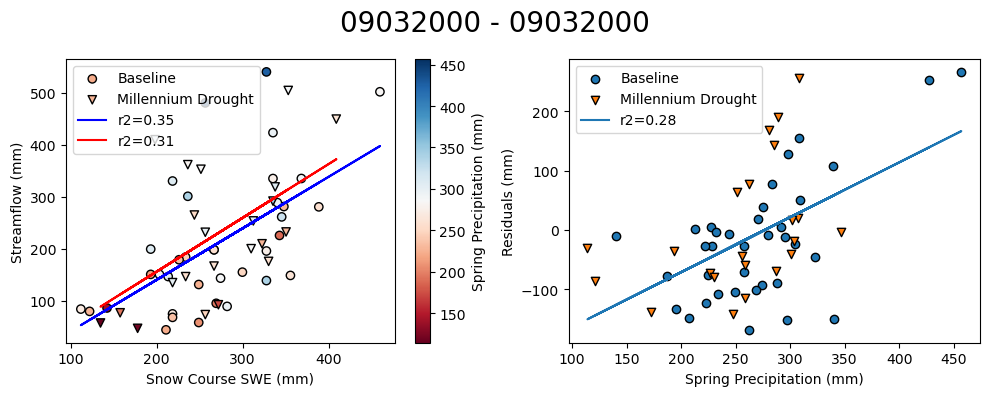

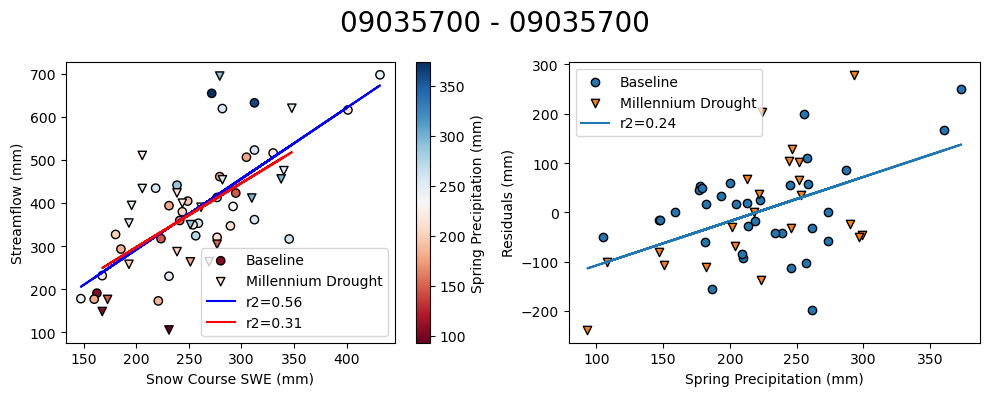

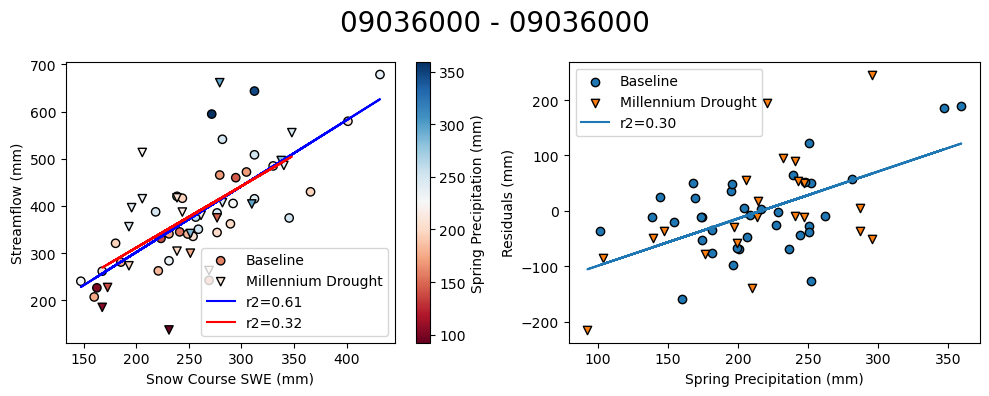

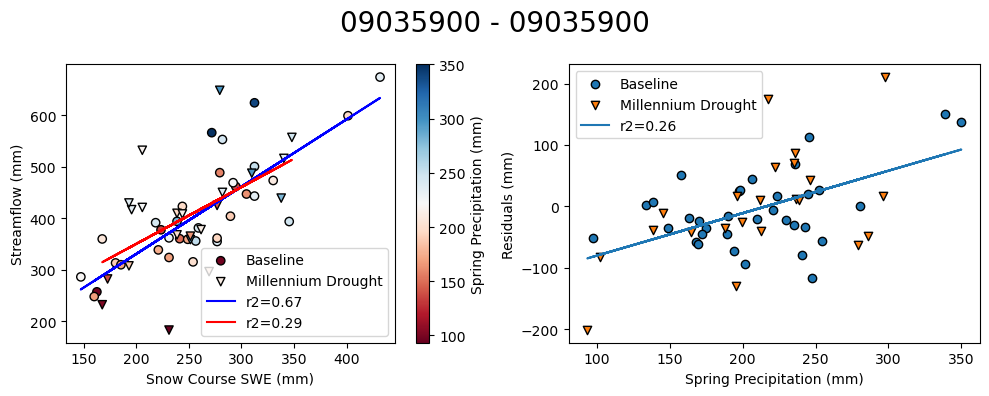

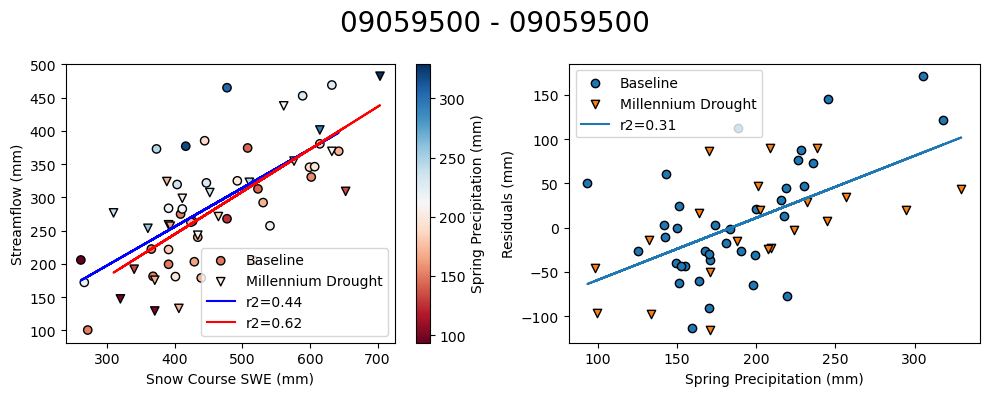

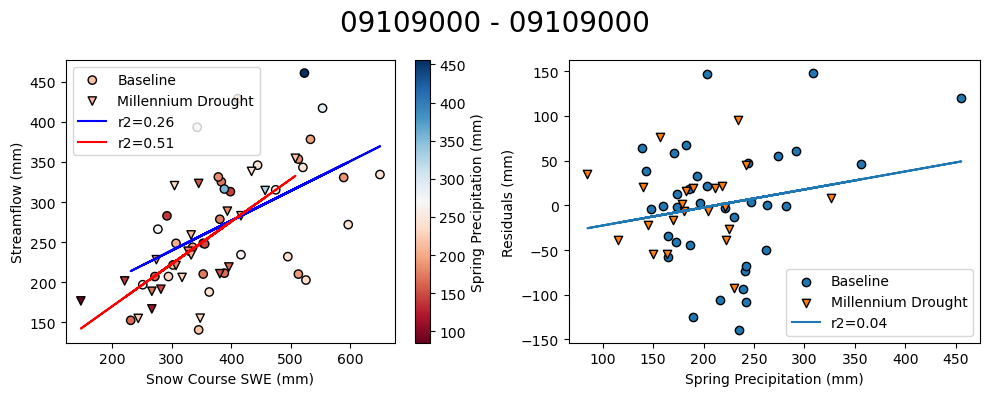

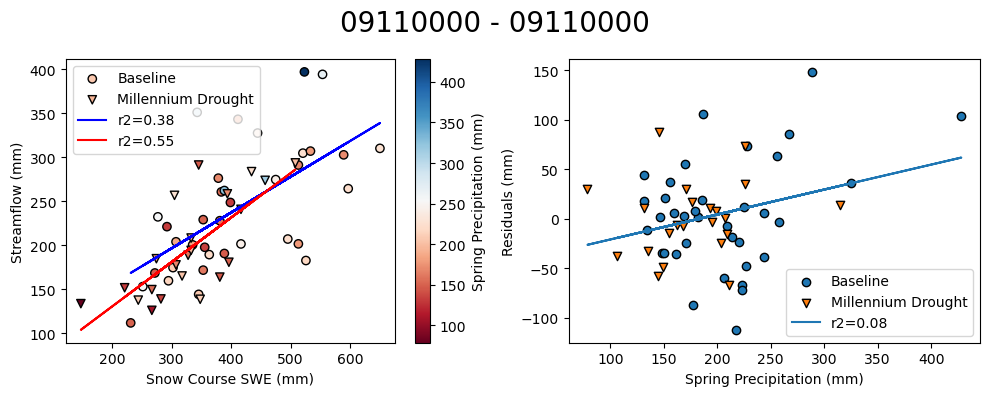

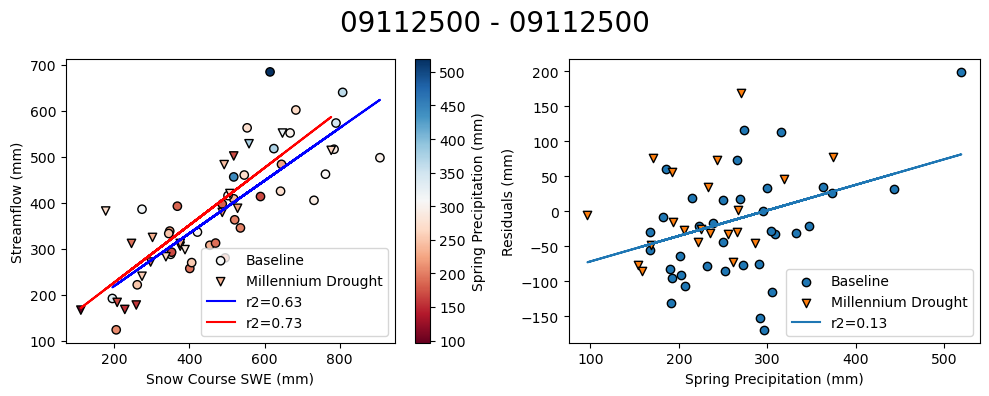

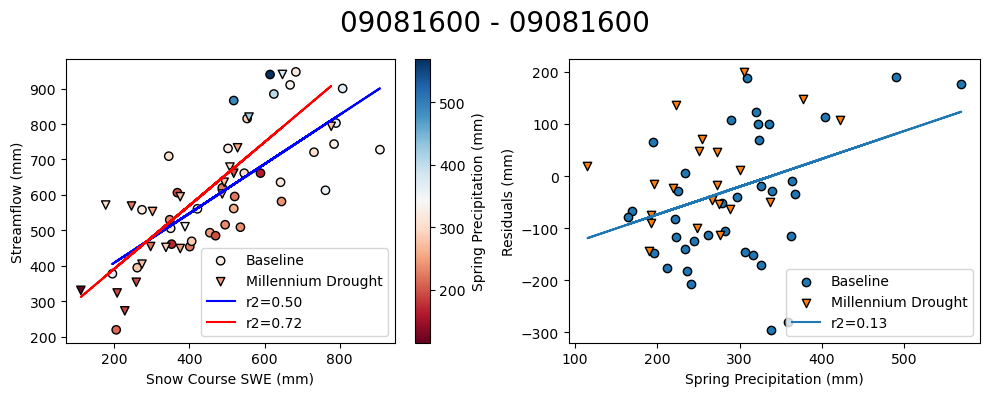

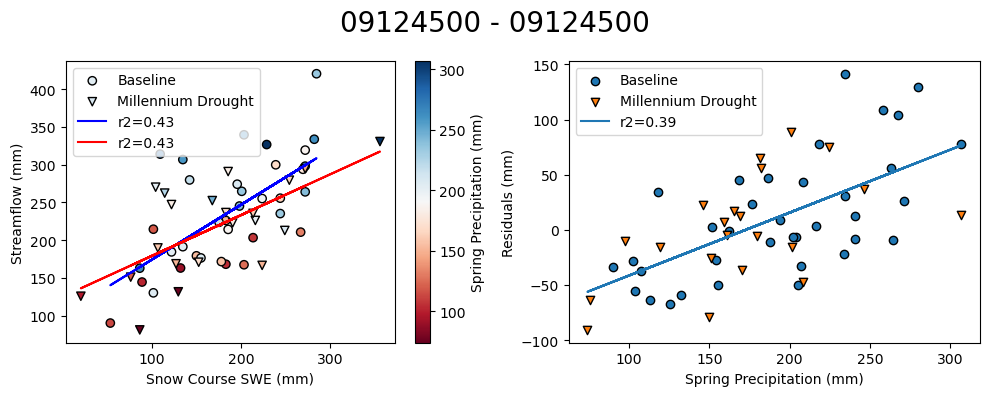

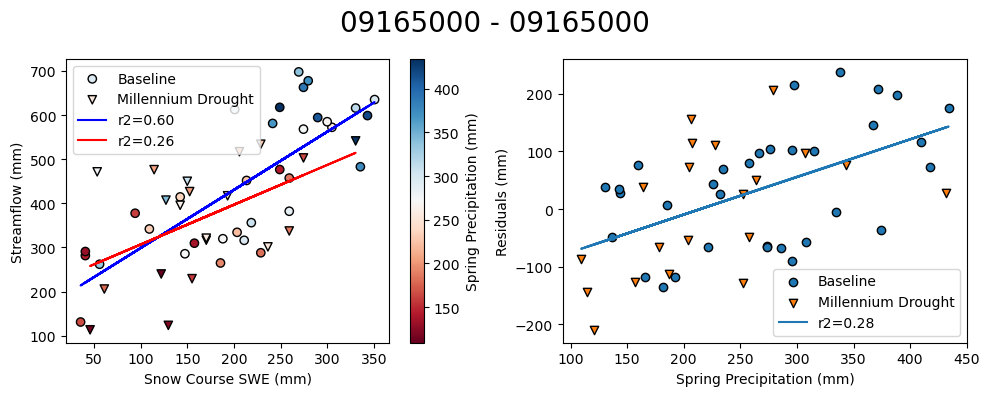

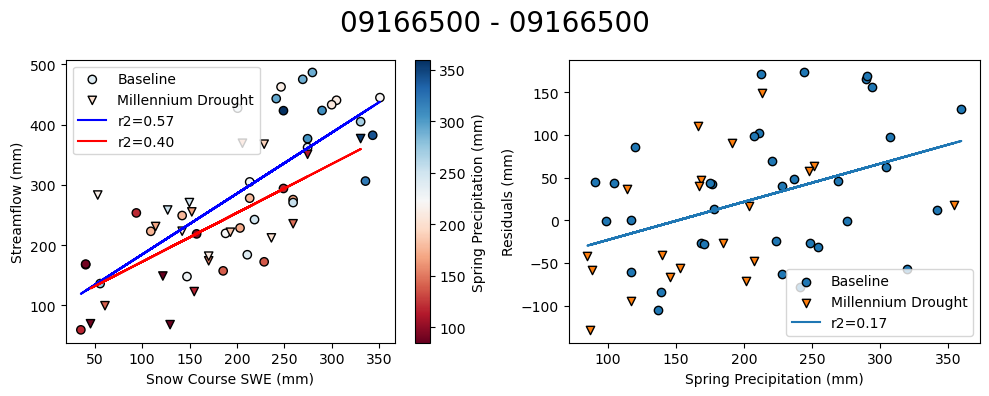

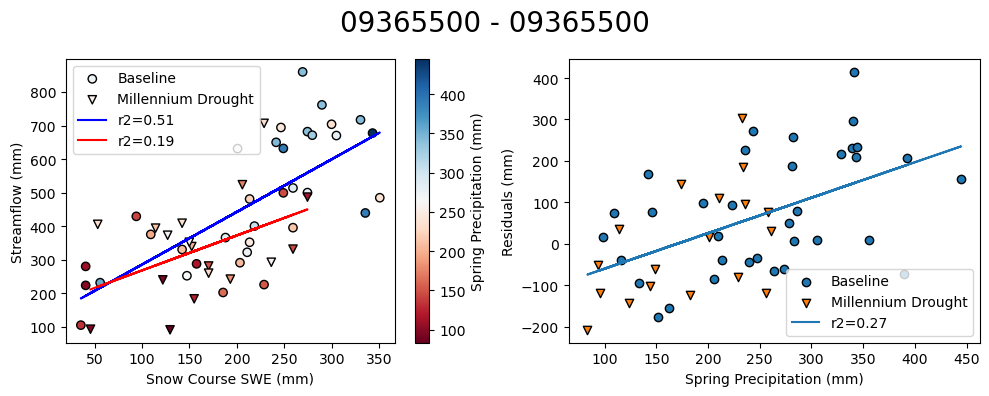

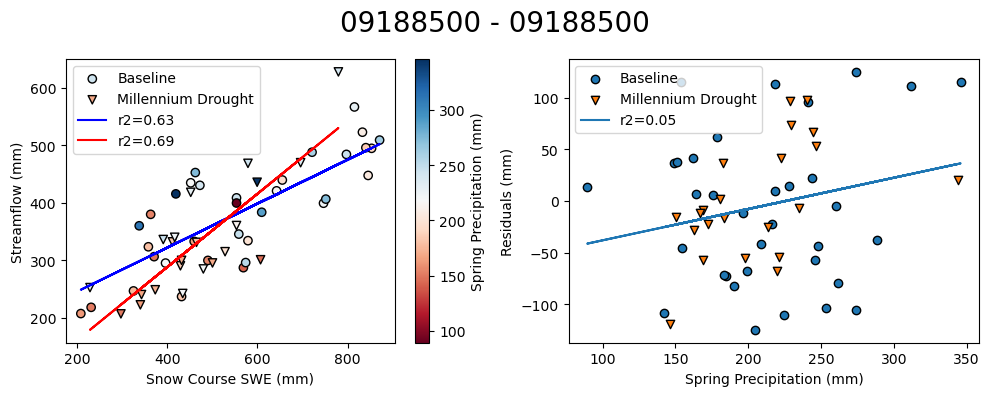

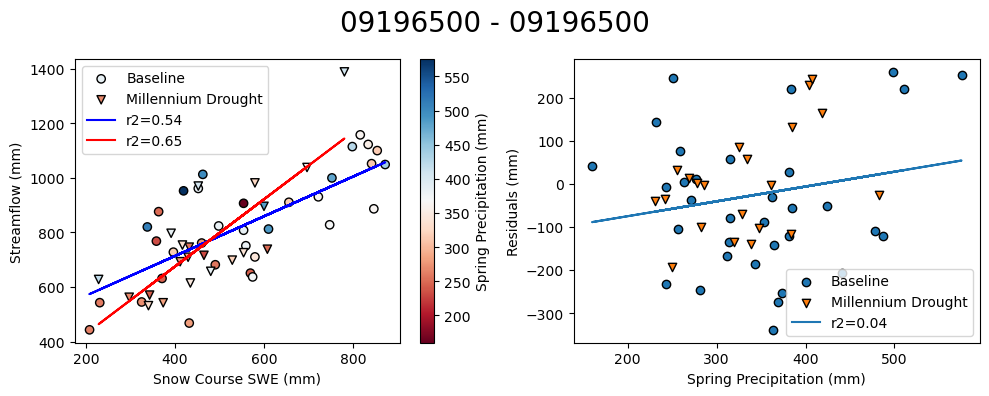

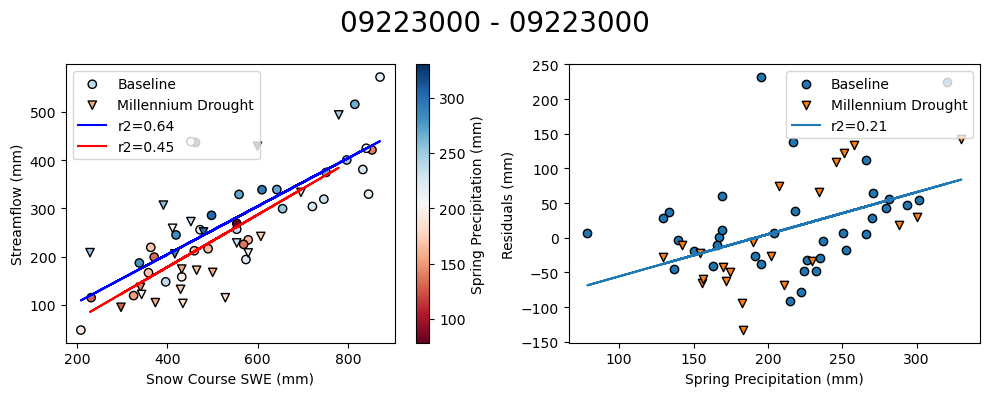

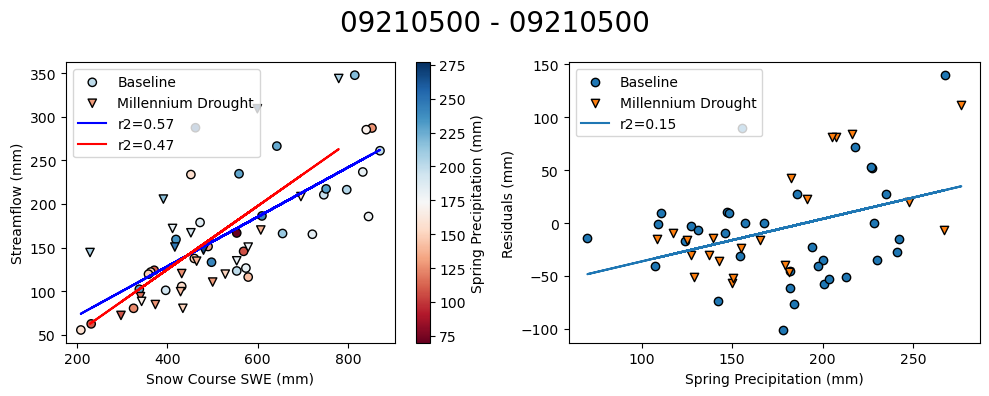

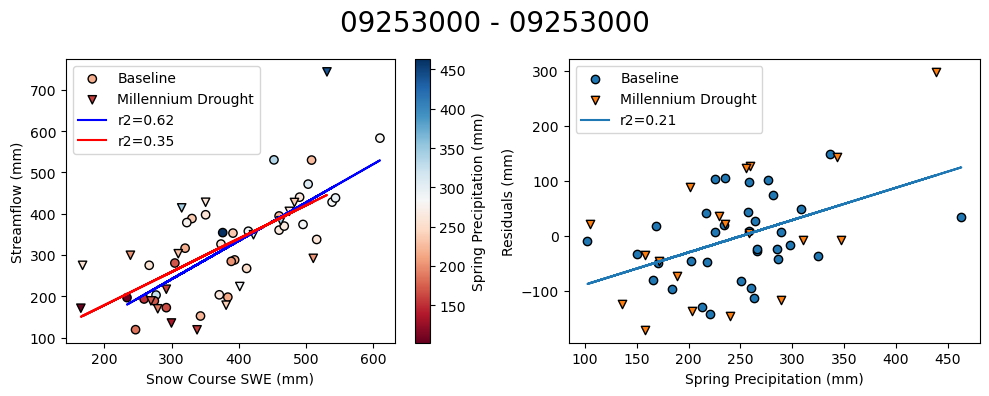

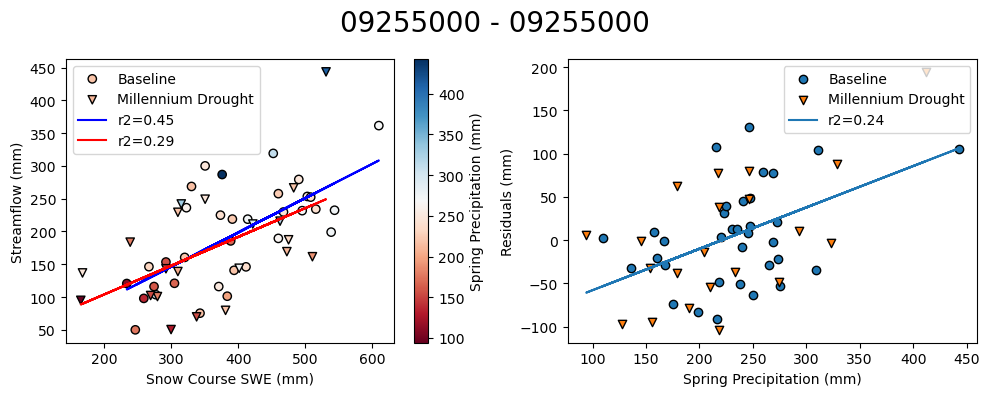

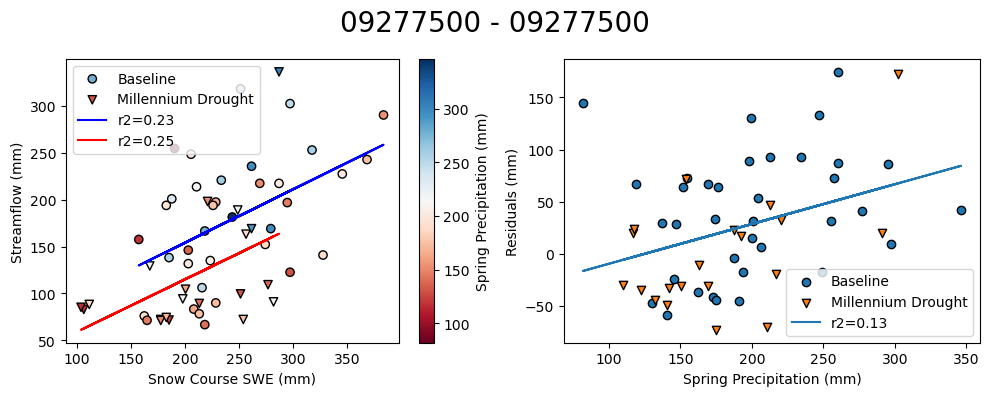

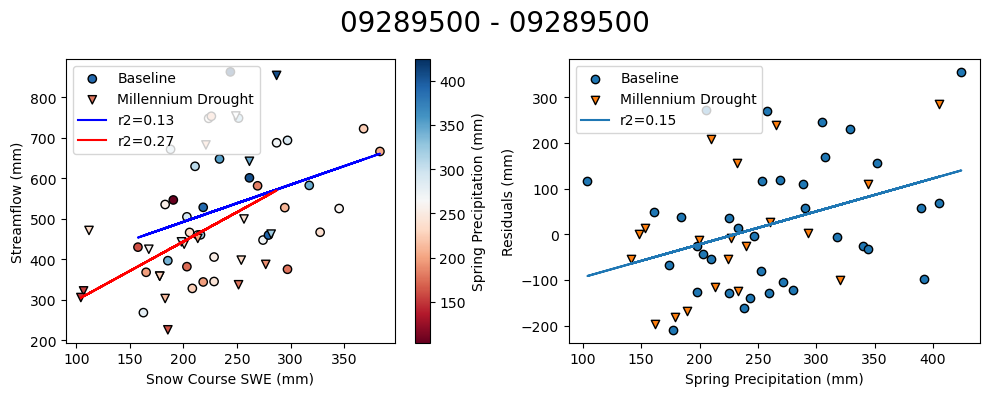

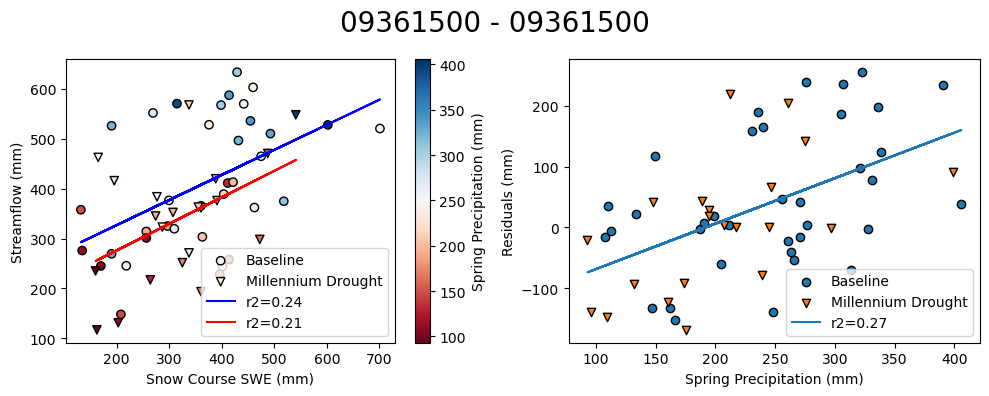

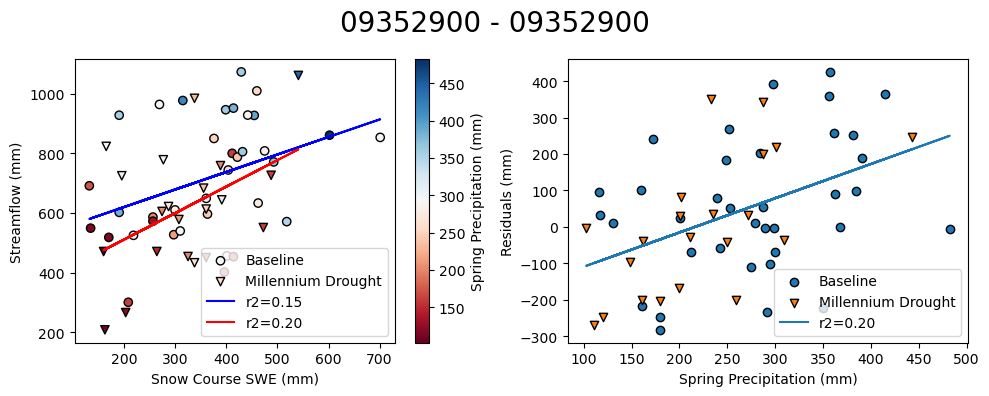

In [33]:
for i,site in enumerate(hcdn_annual_q.site_no.values):
    q = hcdn_annual_q.sel(site_no=site).wy_q_mm.to_pandas()
    swe = large_spring_p_ds.SWE.isel(site=i).to_pandas().dropna()
    swe.index = swe.index.year
    springp = spring_p_change.sel(station_id=site).ppt.to_pandas()
    #combine these three into a temp dataframe
    temp = pd.concat([q,swe,springp],axis=1).loc[1964:].dropna()
    # set the columns to columns=['q','swe','springp']
    temp.columns = ['q','swe','springp']
    # temp = temp[temp['springp']!=temp['springp'].max()]
    fig, axs = plt.subplots(ncols=2, figsize=(10,4), tight_layout=True)
    im=axs[0].scatter(temp.swe,temp.q,c=temp.springp, cmap='RdBu', ec='k',s=1)
    axs[0].scatter(temp.swe.loc[:1999],temp.q.loc[:1999],c=temp.springp.loc[:1999], cmap='RdBu', ec='k', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Baseline')
    im=axs[0].scatter(temp.swe.loc[2000:],temp.q.loc[2000:],c=temp.springp.loc[2000:], cmap='RdBu', ec='k', marker='v', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Millennium Drought')
    # add a colorbar
    cbar = plt.colorbar(im,ax=axs[0])
    cbar.set_label('Spring Precipitation (mm)')
    axs[0].set_xlabel('Snow Course SWE (mm)')
    axs[0].set_ylabel('Streamflow (mm)')
    # add a best fit line using linregress and add the r2 value to the legend for Baseline and MD
    m, b, r, p, std_err = stats.linregress(temp.swe.loc[:1999],temp.q.loc[:1999])
    axs[0].plot(temp.swe.loc[:1999], m*temp.swe.loc[:1999] + b, label=f'r2={r**2:.2f}', color='blue')
    # add a best fit line using linregress and add the r2 value to the legend for Baseline and MD
    m, b, r, p, std_err = stats.linregress(temp.swe.loc[2000:],temp.q.loc[2000:])
    axs[0].plot(temp.swe.loc[2000:], m*temp.swe.loc[2000:] + b, label=f'r2={r**2:.2f}', color='red')
    axs[0].legend()
    
    # calculate the residuals
    residuals = temp.q - (m*temp.swe + b)
    # plot the residuals against the spring precipitation
    axs[1].scatter(temp.springp.loc[:1999],residuals.loc[:1999], ec='k', label='Baseline')
    axs[1].scatter(temp.springp.loc[2000:],residuals.loc[2000:], ec='k', marker='v', label='Millennium Drought')
    # add a best fit line with r2 value in the legend using stats.linregress
    m, b, r, p, std_err = stats.linregress(temp.springp,residuals)
    axs[1].plot(temp.springp, m*temp.springp + b, label=f'r2={r**2:.2f}')
    axs[1].legend()
    axs[1].set_xlabel('Spring Precipitation (mm)')
    axs[1].set_ylabel('Residuals (mm)')
    fig.suptitle(f'{site} - {hcdn_basins_32613.loc[site].name}', fontsize=20)


### <a id='toc4_1_6_'></a>[Tests for significant change between periods](#toc0_)

In [18]:
# Used to remove duplicates
basin_snowcourses_nearest = basin_snowcourses_nearest[~basin_snowcourses_nearest.index.duplicated()]
# pre and post 2000 annual streamflow
pre_hcdn_annual_q = hcdn_annual_q.sel(WY=slice(1964,1999))
post_hcdn_annual_q = hcdn_annual_q.sel(WY=slice(2000,2022))

In [19]:
high_qswe_ttest_results = pd.DataFrame(index=basin_snowcourses_nearest.index, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
conf = 0.05    
    
axs = axs.flatten()                                                                       
for i,site in enumerate(basin_snowcourses_nearest.index):

    # pull in snow course data
    if not type(basin_snowcourses_nearest.loc[site]['id']) == str:
        pre_snow_data = pre_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id'].values[0]).dropna(dim='datetime').SWE.to_pandas()
        post_snow_data = post_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id'].values[0]).dropna(dim='datetime').SWE.to_pandas()
        # pull in streamflow data
        pre_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(pre_snow_data.index.year), drop=True).q_mm
        post_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(post_snow_data.index.year), drop=True).q_mm
        pre_q_data = pre_q_data.isel(site_no=0).to_pandas()
        post_q_data = post_q_data.isel(site_no=0).to_pandas()
    else:
        pre_snow_data = pre_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id']).dropna(dim='datetime').SWE.to_pandas().sort_index()
        post_snow_data = post_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id']).dropna(dim='datetime').SWE.to_pandas().sort_index()
        # pull in streamflow data
        pre_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(pre_snow_data.index.year), drop=True).q_mm.to_pandas().sort_index()
        post_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(post_snow_data.index.year), drop=True).q_mm.to_pandas().sort_index()

        # reset index to combine
        pre_snow_data.index = pre_snow_data.index.year
        post_snow_data.index = post_snow_data.index.year

        # concat pre snow and q
        pre_data = pd.concat([pre_snow_data,pre_q_data],axis=1)
        pre_data.columns = ['SWE','q_mm']
        pre_data = pre_data.dropna()
        # concat post snow and q
        post_data = pd.concat([post_snow_data,post_q_data],axis=1)
        post_data.columns = ['SWE','q_mm']
        post_data = post_data.dropna()
    if site == '09066000':
        pre_saved_for_plotting = pre_data
        post_saved_for_plotting = post_data
        site_saved_for_plotting = site
    # fig, ax = plt.subplots(figsize=(8,6)) 
    # #     # plot pre data
    # ax.scatter(pre_data['SWE'],pre_data['q_mm'])
    # # plot the best fit line
    # m, b = np.polyfit(pre_data['SWE'],pre_data['q_mm'], 1)  
    # ax.plot(pre_data['SWE'], m*pre_data['SWE'] + b, label="Baseline")

    # ax.scatter(post_data['SWE'],post_data['q_mm'])
    # # # plot the best fit line
    # m, b = np.polyfit(post_data['SWE'],post_data['q_mm'], 1)
    # ax.plot(post_data['SWE'], m*post_data['SWE'] + b,label=f"Millennium Drought")
    # fig.suptitle(site, fontsize=20)
    if i ==0:
        ax.legend()
    # calculate q/swe ratio
    single_site_pre = (pre_data['SWE'])
    single_site_post = (post_data['SWE'])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_qswe_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 0.05:
        high_qswe_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        high_qswe_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_qswe_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_qswe_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_qswe_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_qswe_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_qswe_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_qswe_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_qswe_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_qswe_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)


# <a id='toc5_'></a>[Figure 1B - SWE - Q relationship shift between periods](#toc0_)
Note the change in the y-intercept, but slope remains consistent. Less Q for unit SWE?

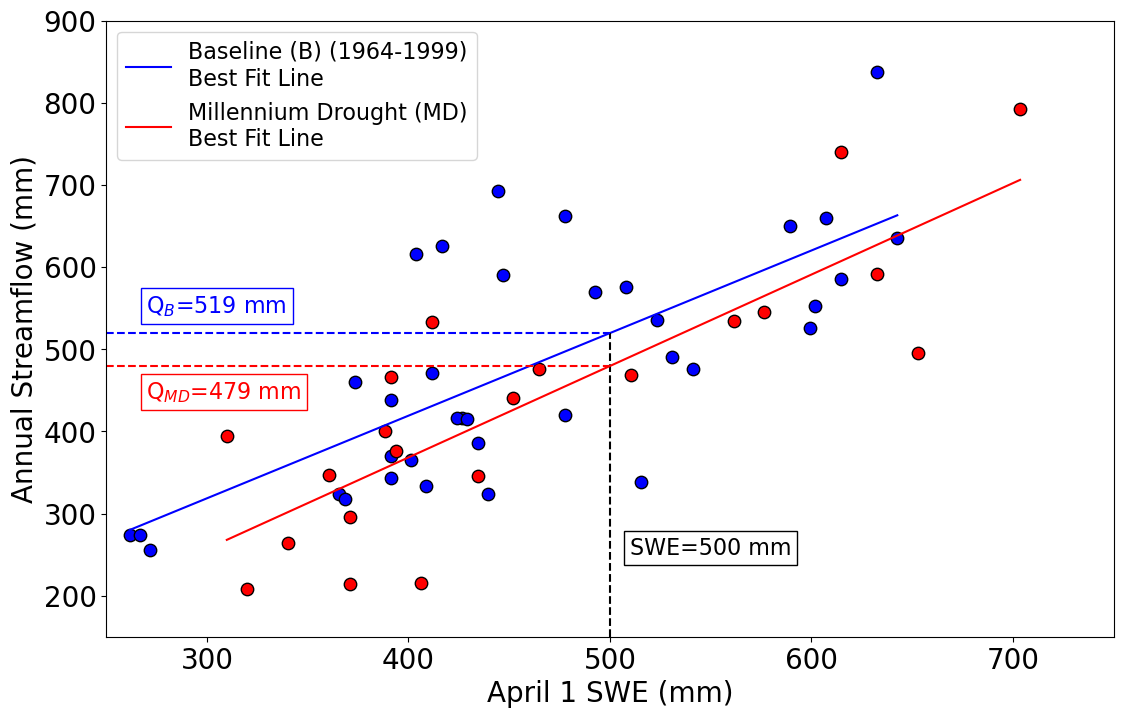

In [22]:
plt.figure(figsize=(13,8))
# plot pre_saved_for_plotting swe against q
plt.scatter(pre_saved_for_plotting['SWE'], 
            pre_saved_for_plotting['q_mm'],
            s=80,
            ec='k',
            color='b',)
# use linregress to add a best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(pre_saved_for_plotting['SWE'], pre_saved_for_plotting['q_mm'])
plt.plot(pre_saved_for_plotting['SWE'].sort_values(), 
        intercept + slope*pre_saved_for_plotting['SWE'].sort_values(), 
        color='blue', 
        label='Baseline (B) (1964-1999)\nBest Fit Line')
# plot a vertical line at a point until it hits the best fit line
plt.plot([500, 500], [150,slope*500+intercept], color='k', linestyle='--')     
# add text in black saying SWE = 500 mm
plt.text(510, 250, 'SWE=500 mm', color='black', fontsize=16,bbox=dict(facecolor='white', alpha=1, ec='k'))
# plot a horizontal line at a point until it hits the best fit line
plt.plot([250, 500], [slope*500+intercept,slope*500+intercept], color='blue', linestyle='--') 
# add a text box below with the value of slope*500+intercept
plt.text(270, slope*500+intercept+25, 'Q$_B$=' +str(int(slope*500+intercept))+" mm", color='blue', fontsize=16,bbox=dict(facecolor='white', alpha=1, ec='blue'))   
# plot post_saved_for_plotting swe against q
plt.scatter(post_saved_for_plotting['SWE'], 
            post_saved_for_plotting['q_mm'],
            s=80,
            ec='k',
            color='r')
# use linregress to add a best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(post_saved_for_plotting['SWE'], post_saved_for_plotting['q_mm'])
plt.plot(post_saved_for_plotting['SWE'].sort_values(), 
         intercept + slope*post_saved_for_plotting['SWE'].sort_values(), 
         color='r', 
         label='Millennium Drought (MD)\nBest Fit Line')
# plot a horizontal line at a point until it hits the best fit line
plt.plot([250, 500], [slope*500+intercept,slope*500+intercept], color='red', linestyle='--')
# add a text box below with the value of slope*500+intercept
plt.text(270, slope*500+intercept-40, 'Q$_{MD}$=' + str(int(slope*500+intercept))+" mm", color='red', fontsize=16, bbox=dict(facecolor='white', alpha=1, ec='red'))
# add labels and legend    
plt.xlabel('April 1 SWE (mm)', size=20)
plt.ylabel('Annual Streamflow (mm)', size=20)
plt.ylim(150,900)
plt.xlim(250,750)
# increase tick label size
plt.tick_params(labelsize=20)
plt.legend(fontsize=16, loc='upper left')
# plt.title('UCRB Headwater Basin (Black Gore Creek)\nSnow Course and Annual Streamflow', size=14)
plt.savefig('../figures/swe_q_relaitonship.svg', dpi=700, pad_inches=0.1)

### <a id='toc5_1_1_'></a>[Linear Regression Plots with spring precipitation added](#toc0_)

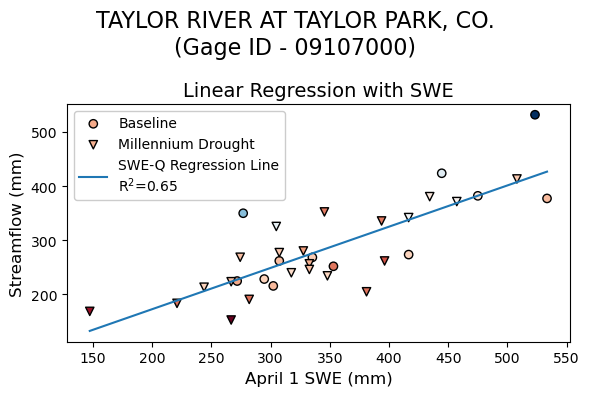

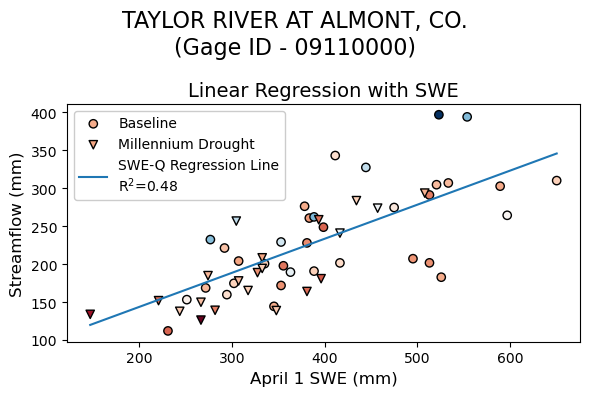

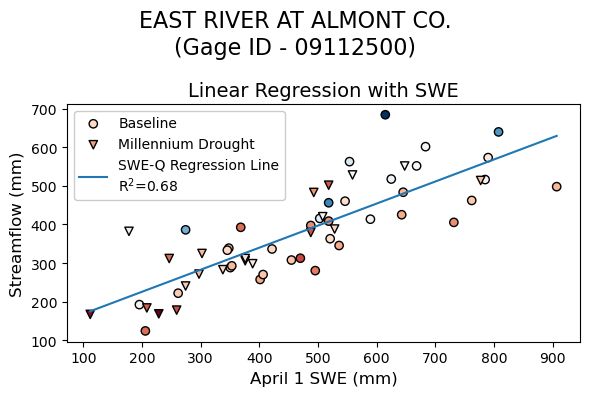

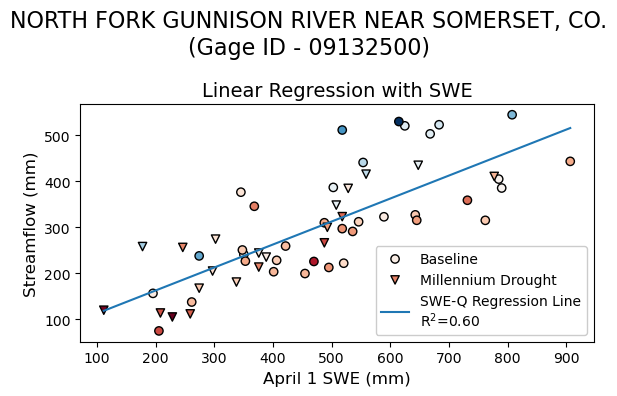

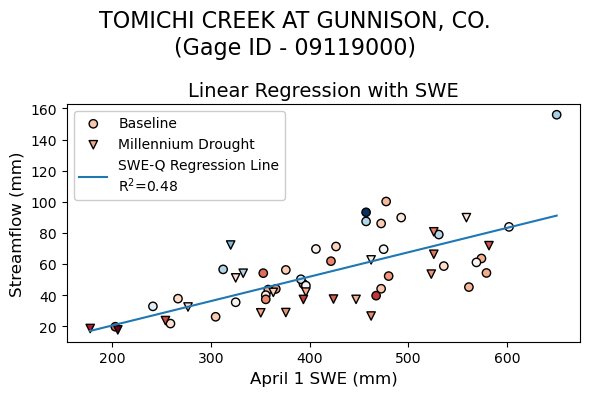

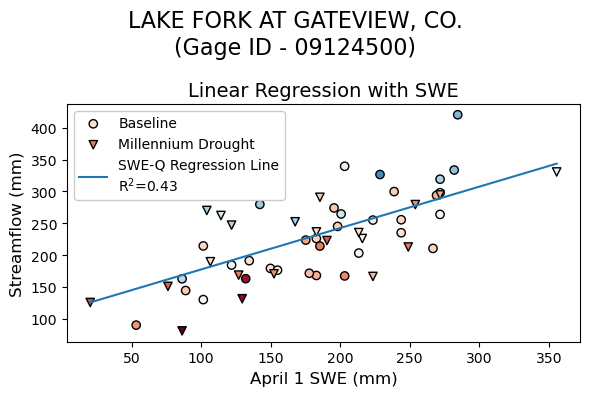

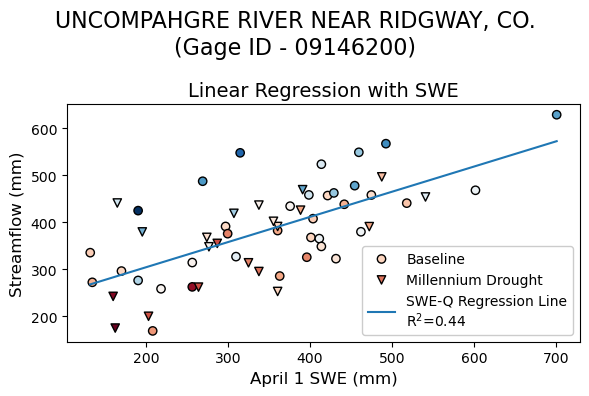

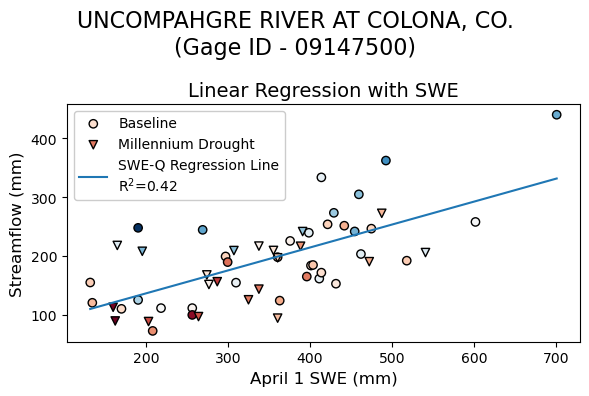

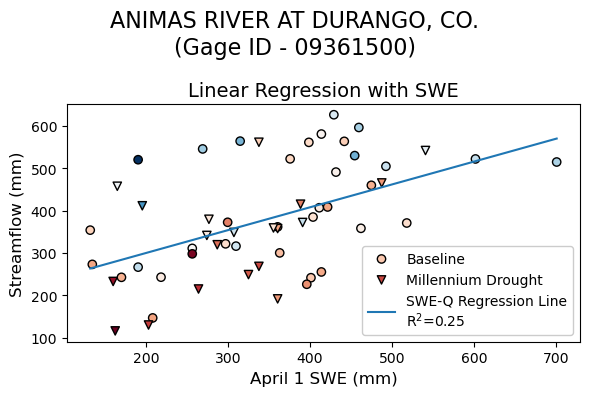

In [23]:
for i,site in enumerate(hcdn_springp_change_q.site_no.values):
    q = hcdn_springp_change_q.sel(site_no=site).q_mm.to_pandas()
    swe = large_spring_p_ds.SWE.isel(site=i).to_pandas().dropna()
    swe.index = swe.index.year
    springp = spring_p_change.sel(site_no=site).ppt.to_pandas()
    #combine these three into a temp dataframe
    temp = pd.concat([q,swe,springp],axis=1).loc[1964:].dropna()
    # set the columns to columns=['q','swe','springp']
    temp.columns = ['q','swe','springp']
    # temp = temp[temp['springp']!=temp['springp'].max()]
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, sharey=True)
    im=ax.scatter(temp.swe,temp.q,c=temp.springp, cmap='RdBu', ec='k',s=1)
    ax.scatter(temp.swe.loc[:1999],temp.q.loc[:1999],c=temp.springp.loc[:1999], cmap='RdBu', ec='k', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Baseline')
    im=ax.scatter(temp.swe.loc[2000:],temp.q.loc[2000:],c=temp.springp.loc[2000:], cmap='RdBu', ec='k', marker='v', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Millennium Drought')
    # add a colorbar
    # cbar = plt.colorbar(im,ax=ax)
    # cbar.set_label('Spring Precipitation (mm)')
    # add a best fit line using linregress with swe as the independent variable and q as the dependent variable
    m,b,r,p,std = stats.linregress(temp.swe,temp.q)
    x = np.linspace(temp.swe.min(),temp.swe.max(),100)
    y = m*x + b
    ax.plot(x,y, label=f'SWE-Q Regression Line\nR$^2$={r**2:.2f}')
    ax.legend(framealpha=1)
    ax.set_xlabel('April 1 SWE (mm)', size=12)
    ax.set_ylabel('Streamflow (mm)',size=12)
    ax.set_title('Linear Regression with SWE',size=14)
    
    for ax in axs:
        ax.grid(True, zorder=0)
    fig.suptitle(f"{hcdn_basins.loc[site]['name']}\n(Gage ID - {site})", size=16)




### <a id='toc5_1_2_'></a>[Multi linear regression with q as the dependent variable and SWE and spring precipitation as the independent variables](#toc0_)

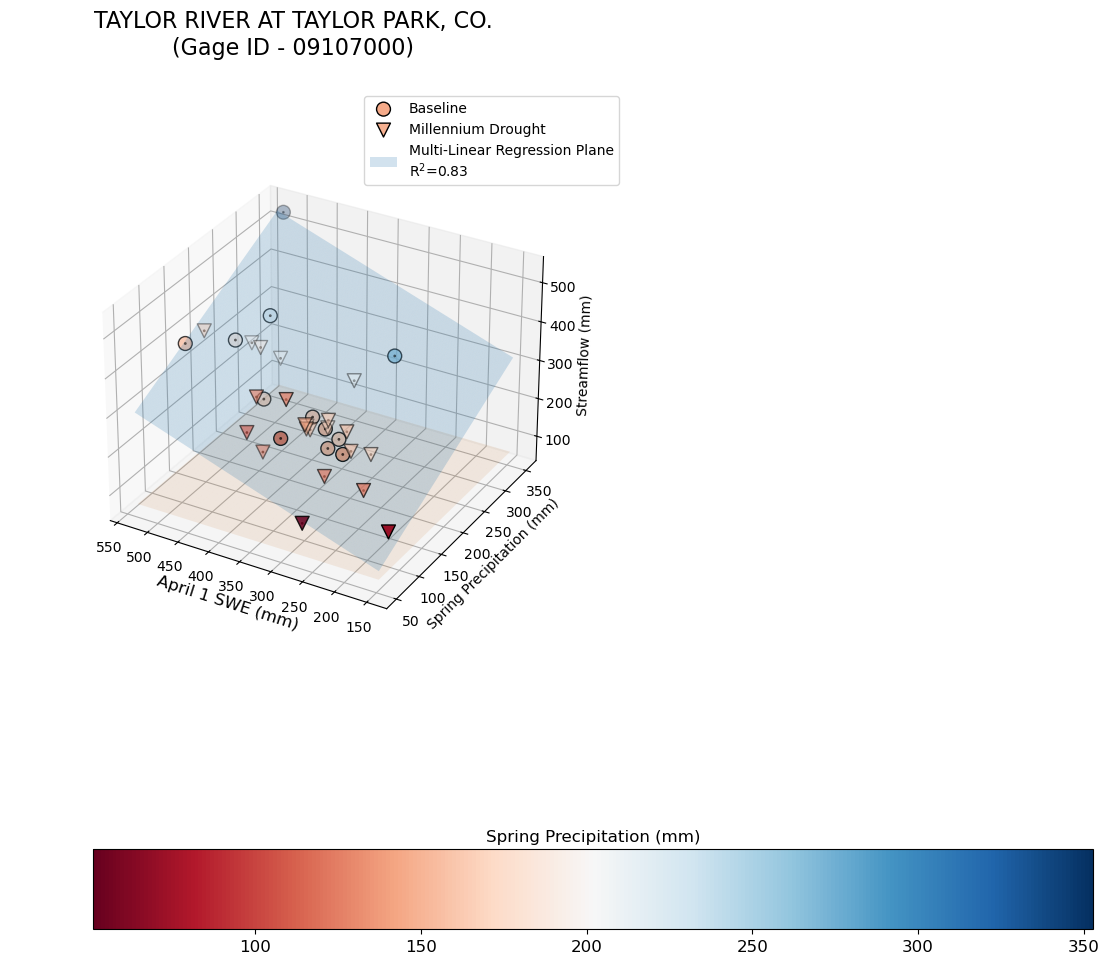

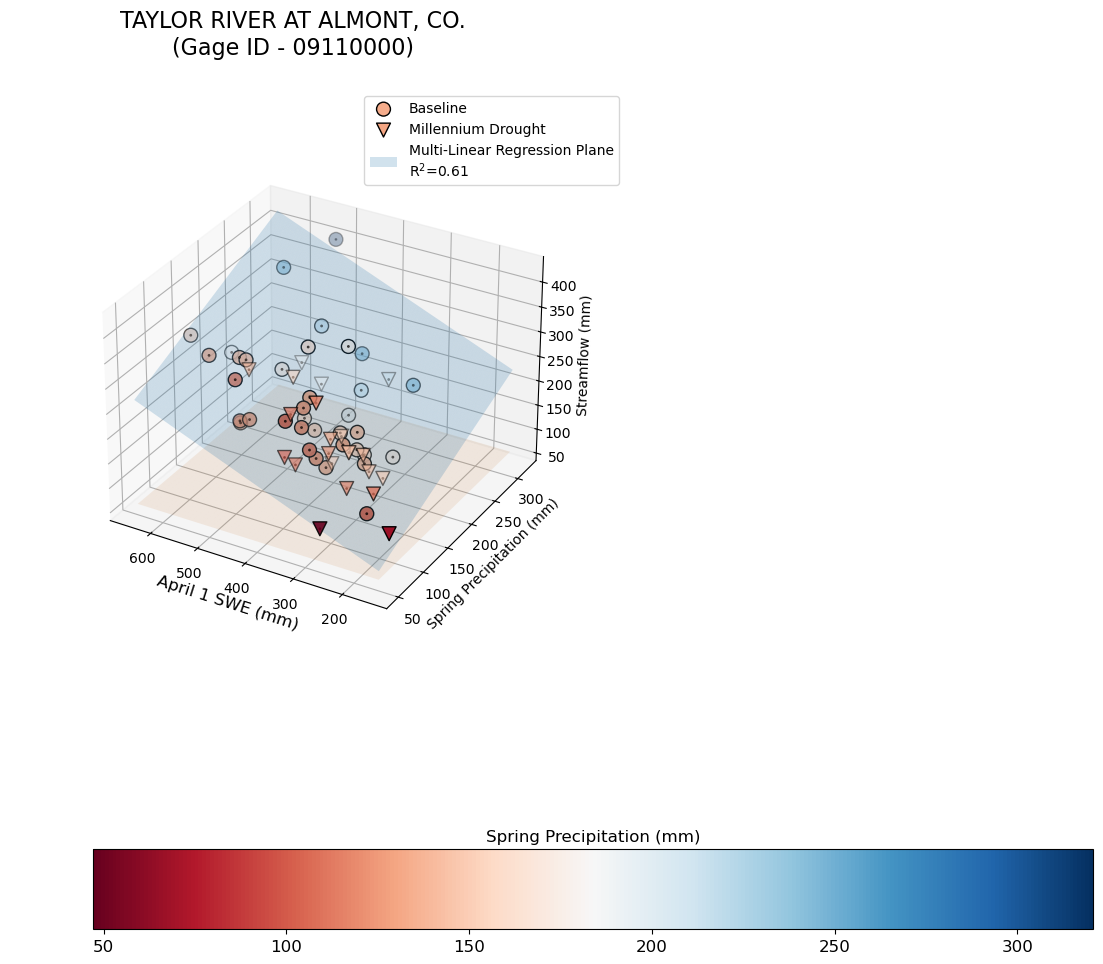

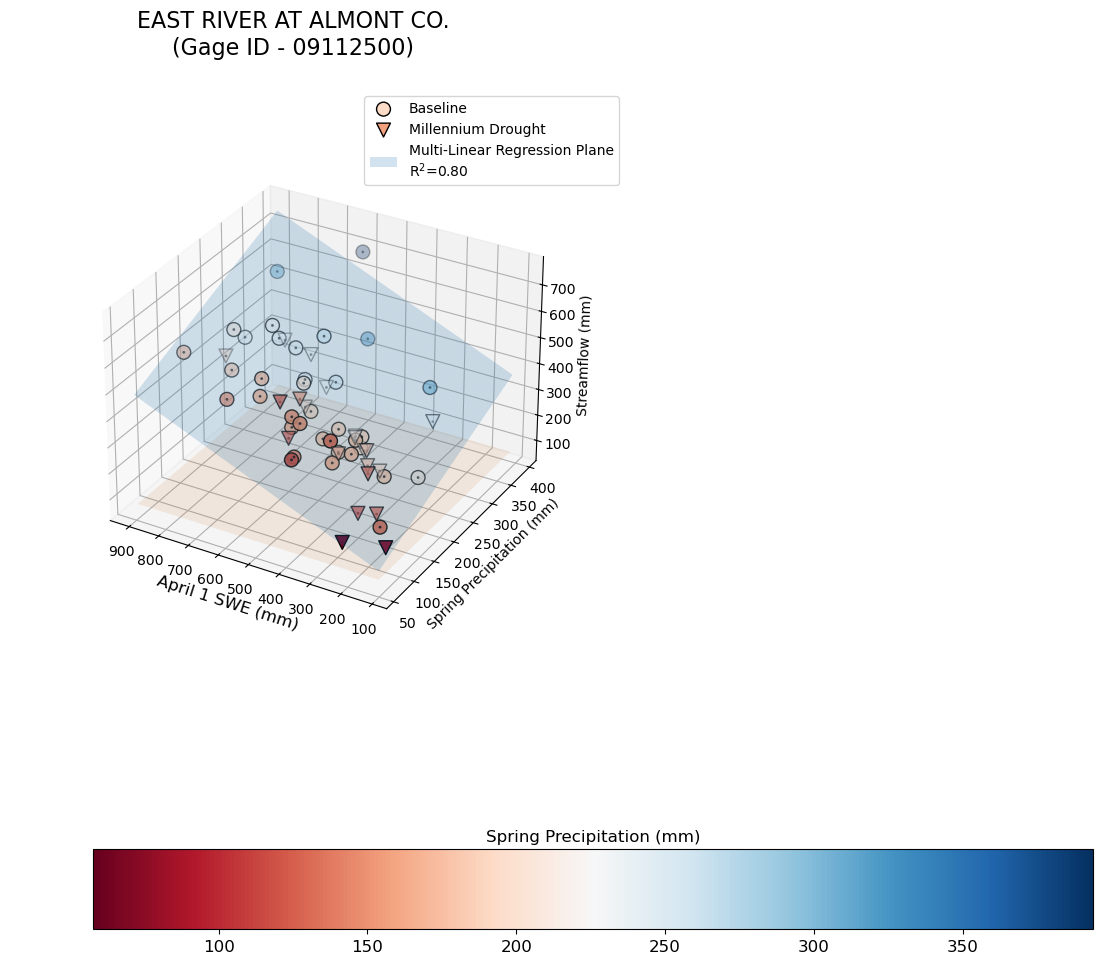

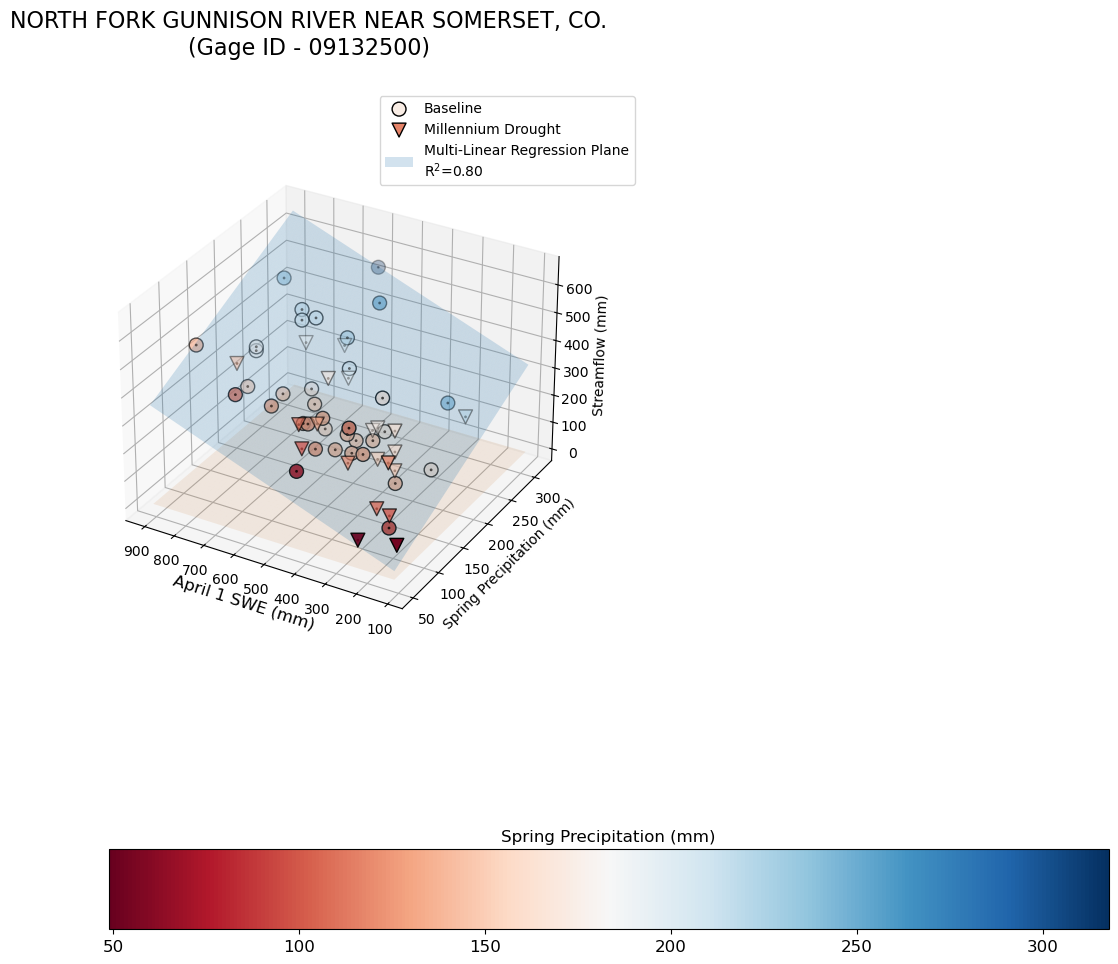

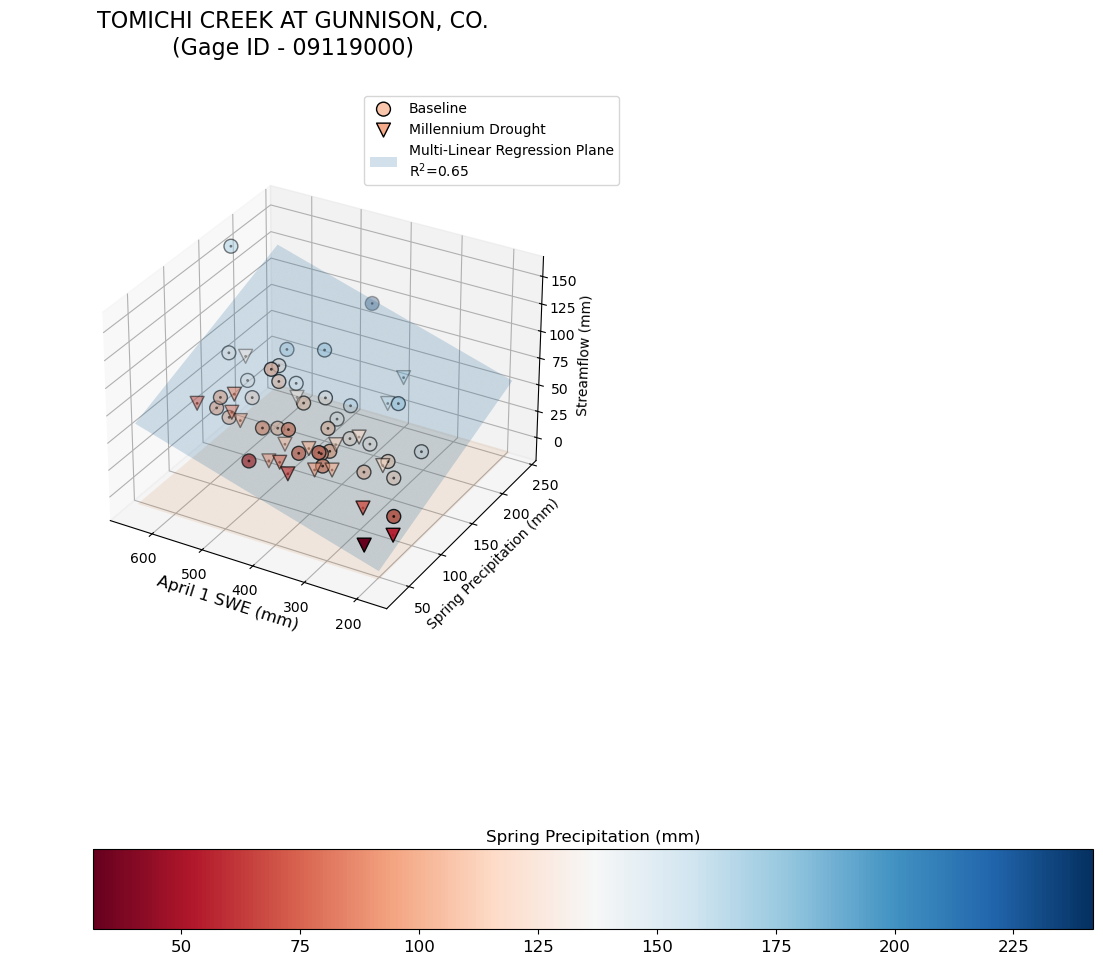

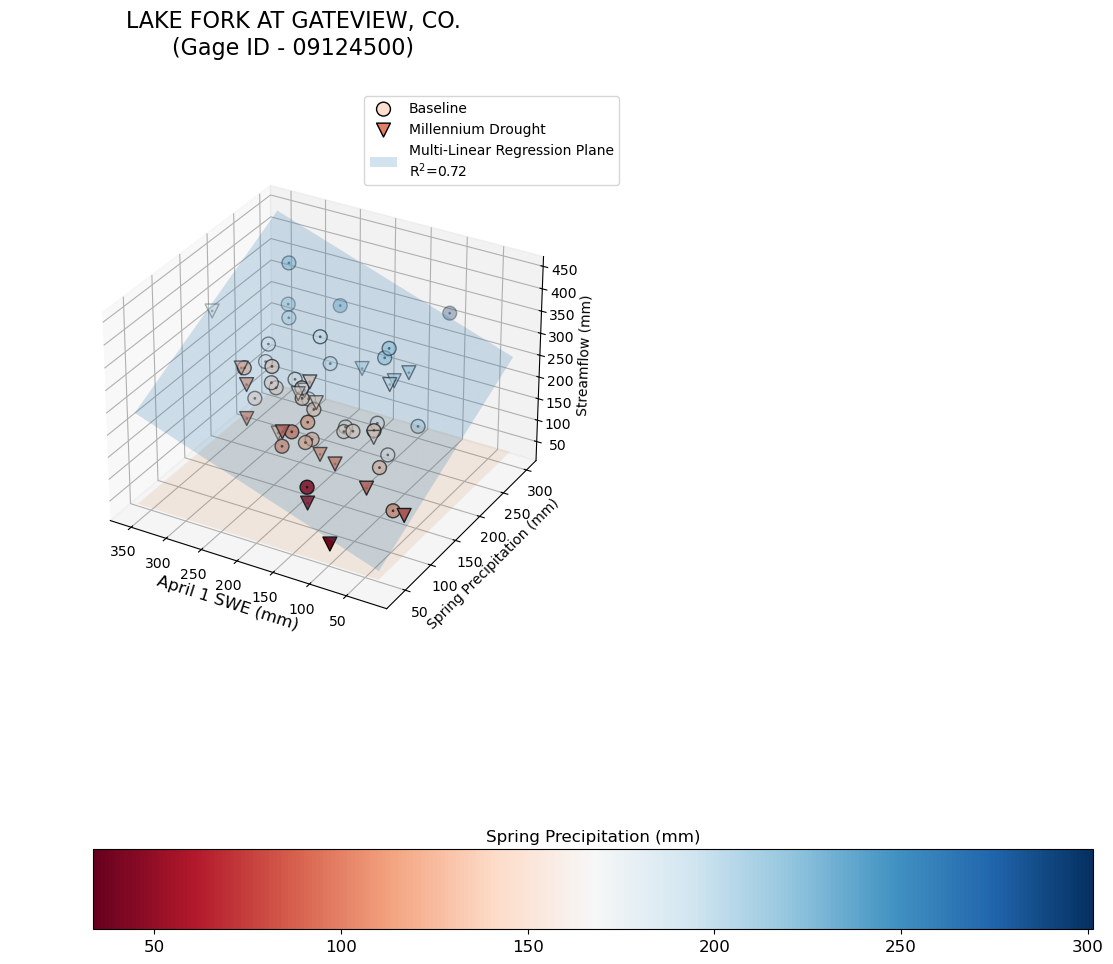

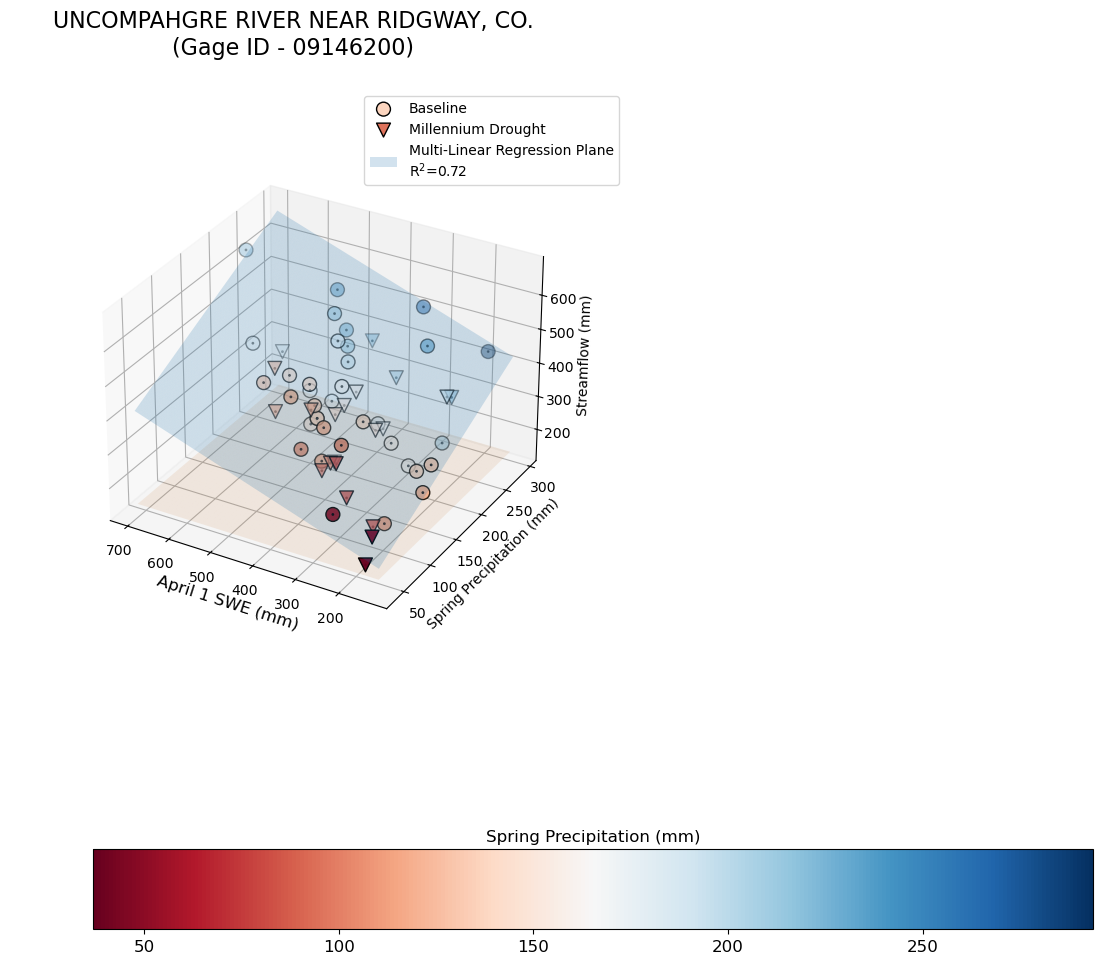

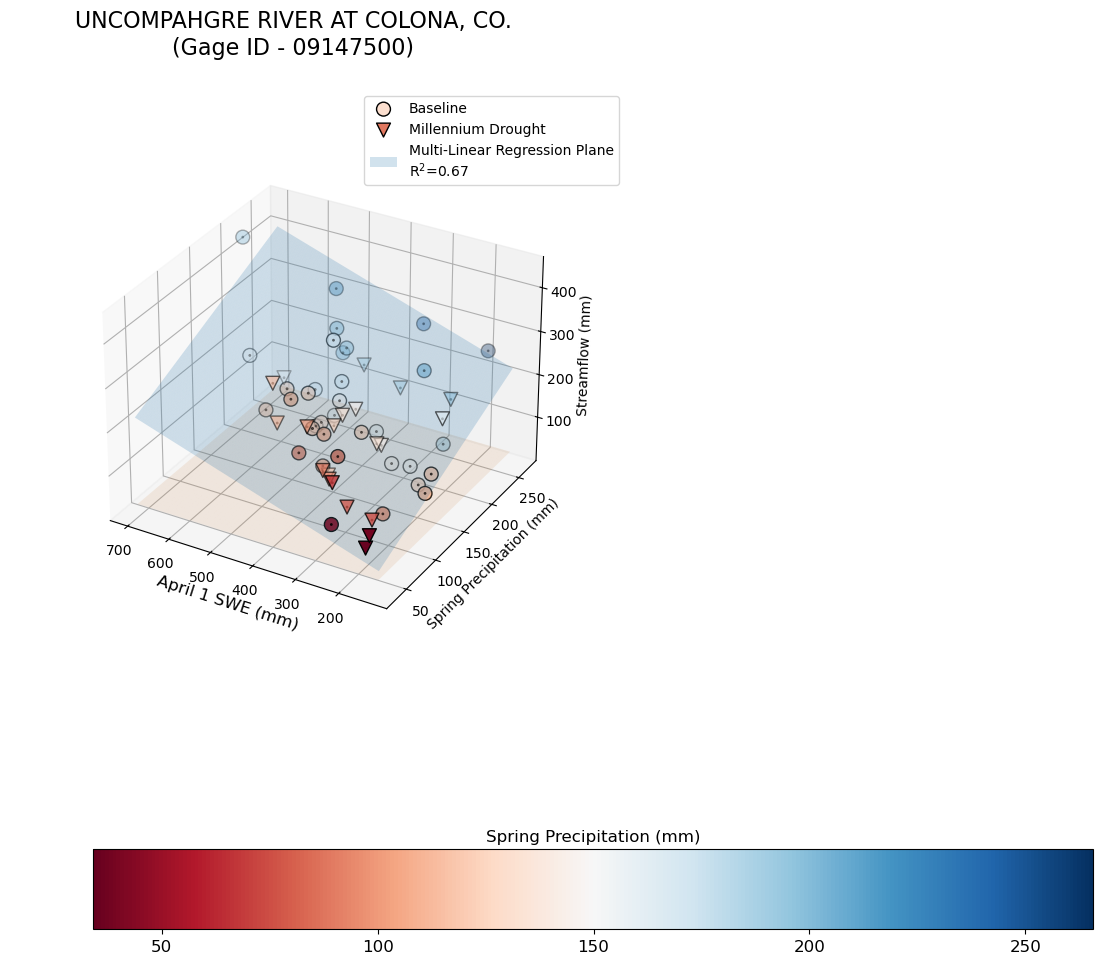

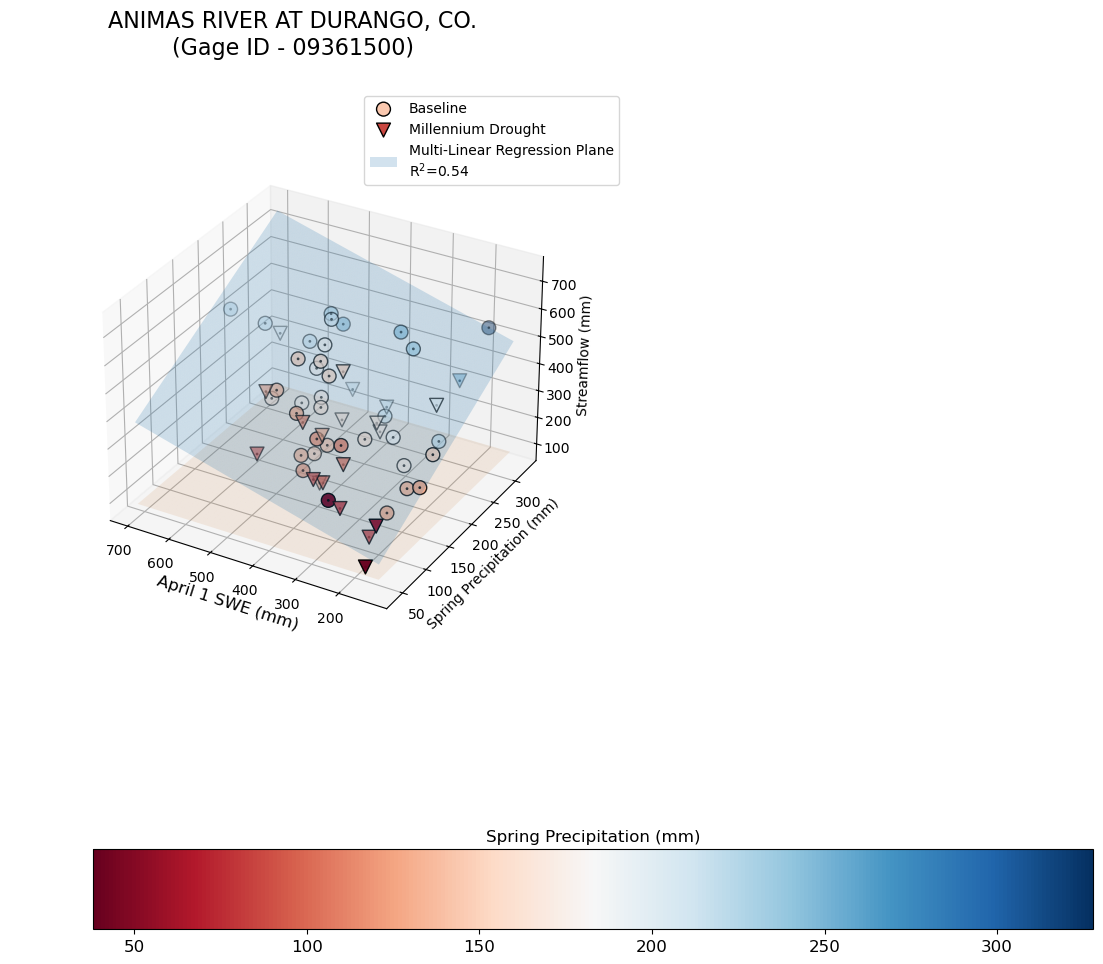

In [27]:
# run a multi linear regression using sm.OLS with q as the dependent variable and swe and springp as the independent variables
# create a 3d plot of the swe, q, and springp data
for i,site in enumerate(hcdn_springp_change_q.site_no.values):
    q = hcdn_springp_change_q.sel(site_no=site).q_mm.to_pandas()
    swe = large_spring_p_ds.SWE.isel(site=i).to_pandas().dropna()
    swe.index = swe.index.year
    springp = spring_p_change.sel(site_no=site).ppt.to_pandas()
    #combine these three into a temp dataframe
    temp = pd.concat([q,swe,springp],axis=1).loc[1964:].dropna()
    # set the columns to columns=['q','swe','springp']
    temp.columns = ['q','swe','springp']

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,8))
    # ax.view_init(elev=20, azim=120, roll=0)
    xsurf=np.linspace(temp.swe.min(),temp.swe.max(),100)
    ysurf=np.linspace(temp.springp.min(),temp.springp.max(),100)
    Xsurf, Ysurf = np.meshgrid(xsurf, ysurf)

    model = sm.ols(formula='q ~ swe + springp', data=temp)
    results = model.fit()
    m1 = results.params.swe
    m2 = results.params.springp
    b = results.params.Intercept
    r2 = results.rsquared
    # create a best fit line using the model results
    x, y = model.exog_names[1:]
    exog = pd.DataFrame({x: Xsurf.ravel(), y: Ysurf.ravel()})
    Z = results.predict(exog = exog).values.reshape(Xsurf.shape)

    # plot data
    im=ax.scatter(temp.swe,temp.springp,temp.q, c=temp.springp, cmap='RdBu', ec='k', s=1,zorder=0)
    ax.scatter(temp.swe.loc[:1999],temp.springp.loc[:1999],temp.q.loc[:1999], c=temp.springp.loc[:1999], cmap='RdBu', ec='k', vmin=temp.springp.min(), vmax=temp.springp.max(), s=100, label='Baseline')
    im=ax.scatter(temp.swe.loc[2000:],temp.springp.loc[2000:],temp.q.loc[2000:],c=temp.springp.loc[2000:], cmap='RdBu', ec='k', marker='v', vmin=temp.springp.min(), vmax=temp.springp.max(),s=100, label='Millennium Drought')
    # plot linear model
    surf = ax.plot_surface(Xsurf, Ysurf, Z, rstride=1, cstride=1, alpha = 0.2,label=f'Multi-Linear Regression Plane\nR$^2$={r2:.2f}',)
    ax.plot_surface(Xsurf, Ysurf, np.full_like(Xsurf, ax.get_zlim()[0]), alpha = 0.1)

    surf._edgecolors2d = surf._edgecolor3d
    surf._facecolors2d = surf._facecolor3d

    ax.legend()
    # add a colorbar to span the whole figure on the top
    cbar_ax = fig.add_axes([0.4, -0.17, 0.5, 0.1])
    cbar = fig.colorbar(im, 
                    cax=cbar_ax, 
                    orientation='horizontal', 
                    )
    # increase the size of the cbar title
    cbar.ax.set_title('Spring Precipitation (mm)', size=12)
    cbar.ax.tick_params(labelsize=12)                 

    ax.set_xlabel('April 1 SWE (mm)', size=12)
    ax.set_ylabel('Spring Precipitation (mm)')
    ax.set_zlabel('Streamflow (mm)')
    ax.set_box_aspect(aspect=None, zoom=0.8)

    ax.invert_xaxis()
    
    fig.suptitle(f"{hcdn_basins.loc[site]['name']}\n(Gage ID - {site})", size=16)